In [1]:
import geopandas as gpd
import cdsapi
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import rioxarray
from rasterio.features import geometry_mask
import plotly.express as px
import glob
import os

In [2]:
IF_DOWNLOAD=False
LOCATION_PATH='locations/chn_admbnda_adm2_ocha_2020.shp'

In [3]:
def query_data(years, dataset, request):

    for year in years:
        request['year']=year
        client = cdsapi.Client()
        client.retrieve(dataset, request, target=f"rainfall/era5_rainfall_{year}.nc")

if IF_DOWNLOAD:
    years=[str(year) for year in range(1990, 2025)]
    dataset = "derived-era5-single-levels-daily-statistics"
    request = {
        "product_type": "reanalysis",
        "variable": ["total_precipitation"],
        "month": ["08", "09", "10"],
        "day": [
            "01", "02", "03",
            "04", "05", "06",
            "07", "08", "09",
            "10", "11", "12",
            "13", "14", "15",
            "16", "17", "18",
            "19", "20", "21",
            "22", "23", "24",
            "25", "26", "27",
            "28", "29", "30",
            "31"
        ],
        "daily_statistic": "daily_mean",
        "time_zone": "utc+00:00",
        "frequency": "6_hourly",
        "area": [20.5, 108.5, 18, 111.5]
    }

    query_data(years, dataset, request)

    file_list = sorted(glob.glob("rainfall/era5_rainfall_*.nc"))
    file_list = [f for f in file_list if any(str(y) in f for y in range(1990, 2025))]

    ds_combined = xr.open_mfdataset(
        file_list,
        combine="by_coords",
        parallel=False
    )

    print(ds_combined)
    output_folder = "rainfall/processed"
    os.makedirs(output_folder, exist_ok=True)
    ds_combined.to_netcdf(f"{output_folder}/era5_rainfall_1990_2024_combined.nc")

In [4]:
hainan=gpd.read_file(LOCATION_PATH)
hainan=hainan[hainan['ADM1_PCODE']=='CN046']
hainan.drop(columns=['OBJECTID', 'Admin_type', 'Adm2_CAP', 'ADM2_PCODE', 'ADM1_ZH', 'ADM1_PCODE', 'ADM0_EN', 'ADM0_ZH', 'ADM0_PCODE'], inplace=True)

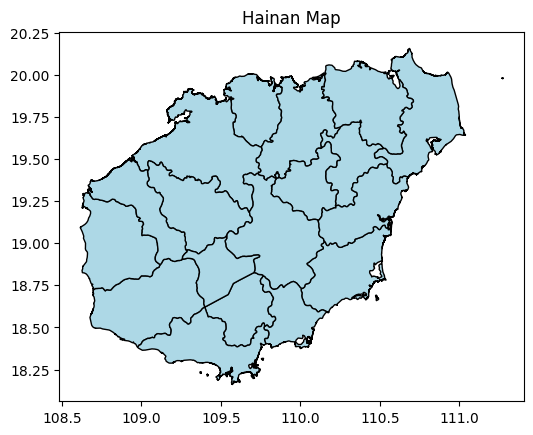

In [5]:
hainan.plot(edgecolor="black", facecolor="lightblue")
plt.title("Hainan Map")
plt.show()

In [6]:
hainan

,ADM2_EN,ADM2_ZH,ADM1_EN,geometry
342,Lingao County,临高县[2],Hainan Province,"POLYGON ((109.84959 19.93765, 109.85564 19.937..."
343,Chengmai County,澄迈县[2],Hainan Province,"MULTIPOLYGON (((110.01894 19.93597, 110.01557 ..."
344,Sansha,三沙市,Hainan Province,"MULTIPOLYGON (((111.27097 19.98208, 111.27097 ..."
345,Wanning City,万宁市[1],Hainan Province,"MULTIPOLYGON (((110.48292 18.67542, 110.48292 ..."
346,Baoting Li and Miao Autonomous County,保亭黎族苗族自治县[2],Hainan Province,"POLYGON ((109.76581 18.80482, 109.76304 18.801..."
347,Ledong Li Autonomous County,乐东黎族自治县[2],Hainan Province,"MULTIPOLYGON (((108.88852 18.42625, 108.8818 1..."
348,Danzhou,儋州市,Hainan Province,"MULTIPOLYGON (((108.94403 19.49431, 108.94403 ..."
349,Ding'an County,定安县[2],Hainan Province,"POLYGON ((110.52322 19.56573, 110.51997 19.562..."
350,Tunchang County,屯昌县[1],Hainan Province,"POLYGON ((110.2206 19.22336, 110.22206 19.2166..."
351,Baisha Li Autonomous County,白沙黎族自治县[2],Hainan Province,"POLYGON ((109.6779 19.184, 109.68147 19.18035,..."


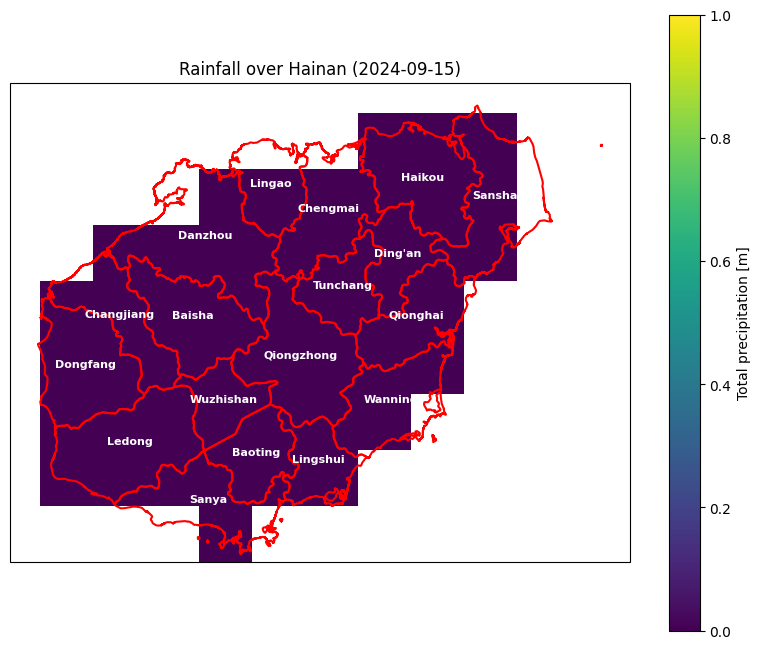

In [7]:
date="2024-09-15"

proj=ccrs.PlateCarree()

fig, ax=plt.subplots(figsize=(10,8), subplot_kw={'projection': proj})
hainan = hainan.to_crs("EPSG:4326")
hainan.boundary.plot(ax=ax, edgecolor='red', linewidth=1.5, transform=proj, zorder=2)
ds = xr.open_dataset("rainfall/processed/era5_rainfall_1990_2024_combined.nc")
da_tcc = ds["tp"]
da_tcc = da_tcc.rio.write_crs("EPSG:4326")
da_day = da_tcc.sel(valid_time=date) 

masked_tcc = da_day.rio.clip(hainan.geometry, hainan.crs, drop=True)

masked_tcc.plot(cmap="viridis", vmin=0, vmax=1)
for _, row in hainan.iterrows():
    city_name=row['ADM2_EN'].split(' ')[0]
    x, y = row.geometry.centroid.x, row.geometry.centroid.y
    ax.text(x,y,city_name, transform=proj, fontsize=8, ha='center', color='white', weight='bold', zorder=3)
plt.title(f"Rainfall over Hainan ({date})")
plt.show()

In [8]:
cities=['Haikou', 'Sanya']

In [9]:
da = ds["tp"]
da = da.rio.write_crs("EPSG:4326")

da_september = da.sel(valid_time=da.valid_time.dt.month == 9)

In [10]:
for city in cities:
    city_shp=hainan[hainan['ADM2_EN']==city]
    city_shp = city_shp.to_crs("EPSG:4326")
    da_clipped = da_september.rio.clip(city_shp.geometry, hainan.crs, drop=True)
    da_avg = da_clipped.mean(dim=["latitude", "longitude"])  

    df = da_avg.to_dataframe(name="rainfall").reset_index()

    fig = px.line(
        df,
        x="valid_time",
        y="rainfall",
        markers=True,
        labels={"rainfall": "Rainfall (m)", "day": "Day of September"},
        title=f"Daily Rainfall over Hainan in September (Multi-year) in {city}"
    )
    fig.update_layout(hovermode="x unified")
    fig.show()
